# Probability

## Steps

1. Understand the problem and the mathematical model and generate data
2. Load the (generated) data and get an overview
3. Try to fit parametric probability distributions
4. Joint  and conditional probabilities, chain rule and Bayes' Theorem

## Understand the problem and the mathematical model and generate data

From [1] we understand the following simplified model for simulating and understanding the spreading of diseases. 

![Epidemic process](img/epidemic_process.png)

A fraction of $\beta$ of the susceptible indivisuals $S$ gets infected each unit of time, say each day. A fraction $\mu$ of the infected recover. A simple generalization is a third parameter $\nu$ and the assumption that only $\nu\mu$ individuals recover, while ${1-\nu}\mu$ individuals die.

This leads to the following system of ordinary differencial equations (ODEs):

\begin{align}
\frac{\delta S}{\delta t} & = -\beta S(t)I(t)\\
\frac{\delta I}{\delta t} & = \beta S(t)I(t) -\mu I(t)\\
\frac{\delta R}{\delta t} & = \nu\mu I(t)\\
\frac{\delta D}{\delta t} & = (1-\nu)\mu I(t)
\end{align}

Given starting values of $S(0)=99, I(0)=1, R(0)=D(0)=0$ and parameter values for $\beta=0.05\%, \mu=1.75\%, \nu=99\%$, we can simulate this system of ODEs.

In `Matlab`, we use the ordinary differencial equation solver `ode45`.

In [308]:
%%file virusSpreading.m
function res = virusSpreading(t, y, beta, mu, nu)
    S=y(1);
    I=y(2);
    R=y(3);
    D=y(4);
    
    res(1,1)=-beta*S*I;
    res(2,1)=beta*S*I-mu*I;
    res(3,1)=nu*mu*I;
    res(4,1)=(1-nu)*mu*I;
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Notebooks/virusSpreading.m'.


In [309]:
%%file simVirusSpreading.m
function res = simVirusSpreading(beta, verbose)
    S0 =99;
    I0 =1;
    R0 = 0;
    D0 = 0;
    y0 = [S0, I0, R0, D0]';
    t_span = [0 500];
    mu = 0.0175;
    nu = 0.99;
    [tSol, ySol] = ode45(@(t,y) virusSpreading(t, y, beta, mu, nu), t_span, y0);
    if verbose
        plot(tSol, ySol);
        legend("Susceptible","Infected","Recovered","Dead");
    end
    res = [tSol, ySol];
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Notebooks/simVirusSpreading.m'.


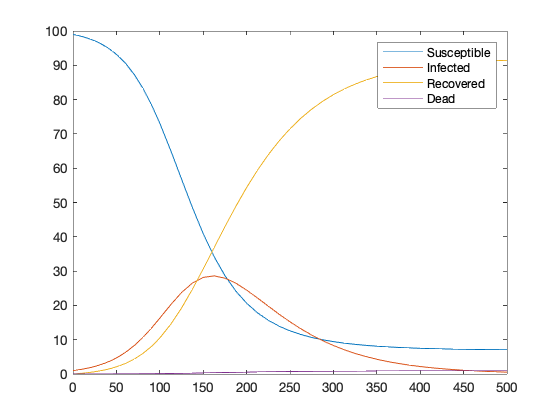

In [310]:
format compact
beta = 0.0005; %0.05%
simVirusSpreading(beta, true);

Note that the development highly depends on the parameter $\beta$. So, if all behave well, the infection risk drops and the infection spreading slows down. Inversely, if we misbehave and increase the risk of infection, the infection spreads faster. Here simulations with $\beta = 0.03\%$ and $\beta = 0.07\%$, respectively.

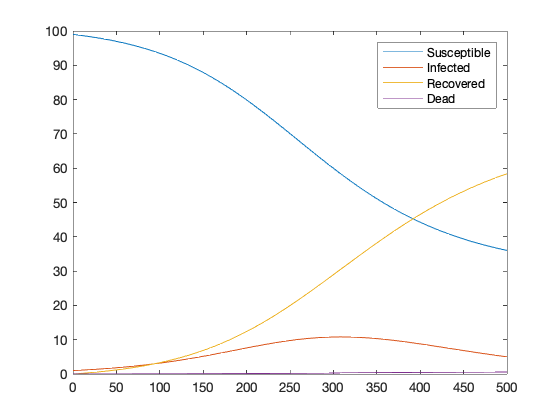

In [311]:
beta = 0.0003;
simVirusSpreading(beta, true);

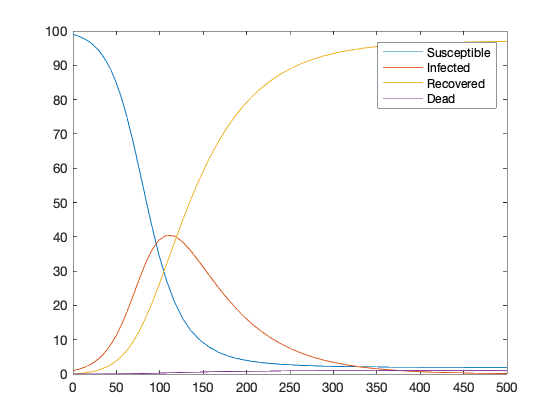

In [312]:
beta = 0.0007;
simVirusSpreading(beta, true);

Of course, the exact parameters values for $\beta, \mu, \nu$ are not known but can only be approximated from observations. The ODE model is an abstraction of the real process, which depends on deterministic but unknown variables and randomness. Therefore, it makes sense to understand disease spreading as a **random process.**

We will generate some observations from this process from different countries and then forget about the process and only work with the observations.

Therefore, we assume that $\beta$ distributes normally around a mean of $\bar \beta = 0.05\%$ with a standard deviation of $\sigma = 0.01\%$. We generate the data for $N=50$ countries. However, we are only "observing" $8$ new features.

1. The numbers $N_{50}, N_{150}, N_{300}$ of infected after $50, 150, 300$ days, resp. 
2. The corresponding numbers of new infections on that day $D_{50}, D_{150}, D_{300}$.
3. The time $T_{peak}$ to peak infection.
4. The total number of casulties $X_{500}$ after $500$ days.

In [313]:
countries = 50;
verbose = false;
if verbose
    N=1;
end
features = zeros(countries,8);
rng('default')  % For reproducibility
betas = normrnd(0.0005,0.0001,[1,countries]);
for i=1:N
    res = simVirusSpreading(betas(i), false);
    times = res(:,1);
    % Add randomness to the observations
    rand_res = zeros(size(res,1),5);
    rand_res(:,1) = times;
    for j=2:5
        rand_res(:,j) = arrayfun(@(x) normrnd(0,0.025*x)+x, res(:,j));
    end
    if verbose
        fprintf("Beta = %.3f%%\n",betas(1)*100);
        plot(times,[res(:,2) rand_res(:,2), res(:,3) rand_res(:,3),res(:,4) rand_res(:,4),res(:,5) rand_res(:,5)]);        
    end
    ti = times(times<=50);
    n_50 = rand_res(length(ti),3);
    d_50 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=150);
    n_150 = rand_res(length(ti),3);
    d_150 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    ti = times(times<=300);
    n_300 = rand_res(length(ti),3);
    d_300 = rand_res(length(ti),3) - rand_res(length(ti)-1,3);
    [M,ii] = max(rand_res(:,3));
    t_peak = times(ii);
    if verbose
        fprintf("n_50=%.4f, n_150=%.4f, n_300=%.4f\nd_50=%.4f, d_150=%.4f, d_300=%.4f\nt_peak=%.4f\nx_500=%.4f\n",n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5) );
    end
    features(i,:)=[n_50, n_150, n_300, d_50, d_150, d_300, t_peak, rand_res(end,5)];
end
writematrix(features,'../2020 DL data/epidemic_process.csv');

## Load the (generated) data and get an overview

This is your starting point. Load the observation data.

In [314]:
features = csvread('../2020 DL data/epidemic_process.csv');

Plot the emperical **cumulative probability distributions** (CDFs) of the **random variables** (features).

stats = 
  struct with fields:

       min: 1.1292
       max: 18.0925
      mean: 5.5108
    median: 4.4227
       std: 3.3964



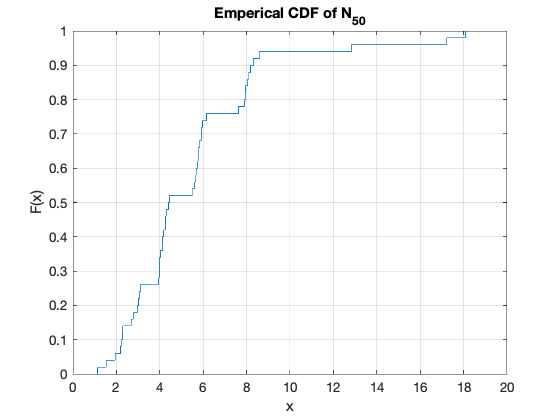

In [315]:
[h,stats] = cdfplot(features(:,1));
title("Emperical CDF of N_{50}")
stats

stats = 
  struct with fields:

       min: 1.5080
       max: 35.5759
      mean: 26.0840
    median: 30.3291
       std: 9.3488



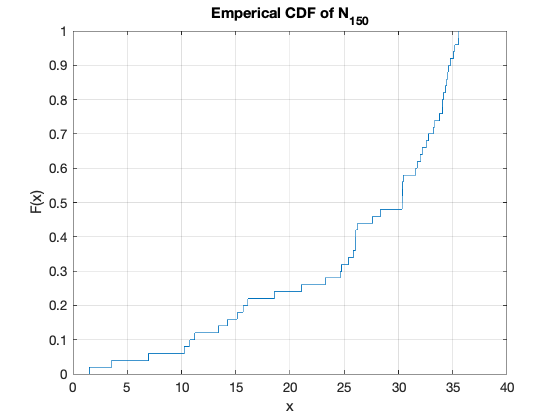

In [316]:
[h,stats] = cdfplot(features(:,2));
title("Emperical CDF of N_{150}")
stats

stats = 
  struct with fields:

       min: 1.8681
       max: 15.4668
      mean: 8.1453
    median: 7.3473
       std: 3.6406



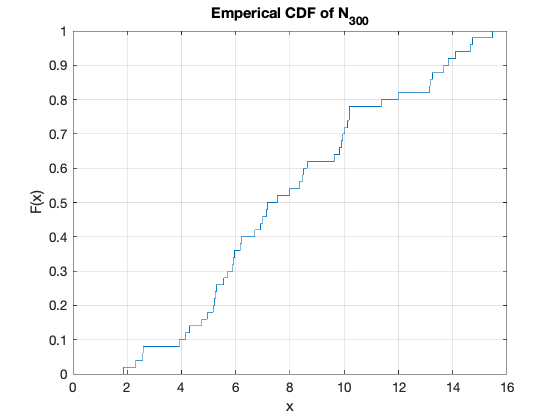

In [317]:
[h,stats] = cdfplot(features(:,3));
title("Emperical CDF of N_{300}")
stats

stats = 
  struct with fields:

       min: 0.0330
       max: 3.9402
      mean: 1.0976
    median: 0.9522
       std: 0.7843



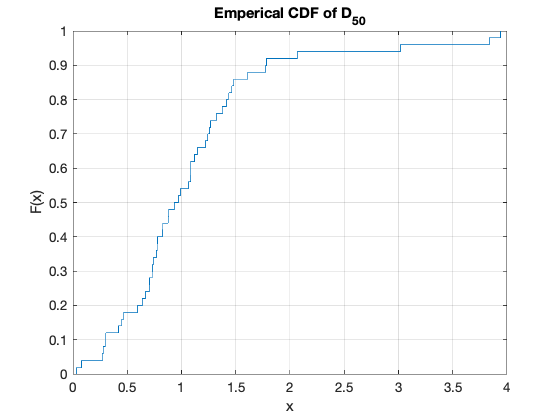

In [318]:
[h,stats] = cdfplot(features(:,4));
title("Emperical CDF of D_{50}")
stats

stats = 
  struct with fields:

       min: -4.5398
       max: 3.8462
      mean: 0.5070
    median: 1.2294
       std: 2.1937



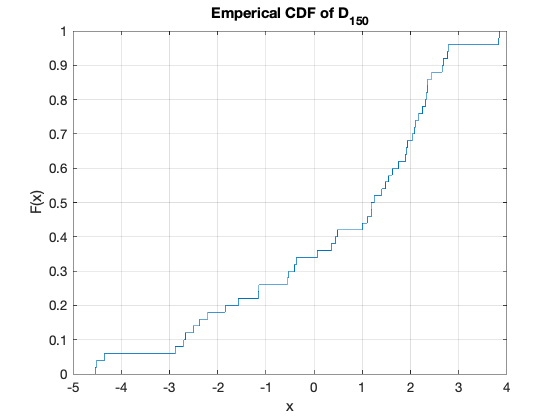

In [319]:
[h,stats] = cdfplot(features(:,5));
title("Emperical CDF of D_{150}")
stats

stats = 
  struct with fields:

       min: -2.2443
       max: 0.0310
      mean: -1.2498
    median: -1.2788
       std: 0.5405



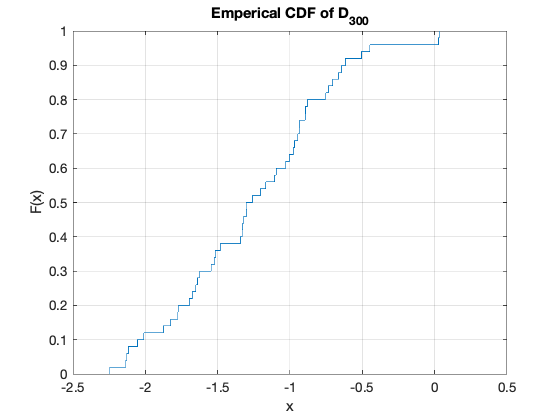

In [320]:
[h,stats] = cdfplot(features(:,6));
title("Emperical CDF of D_{300}")
stats

stats = 
  struct with fields:

       min: 92.3416
       max: 445.3053
      mean: 167.1655
    median: 150.6000
       std: 63.0767



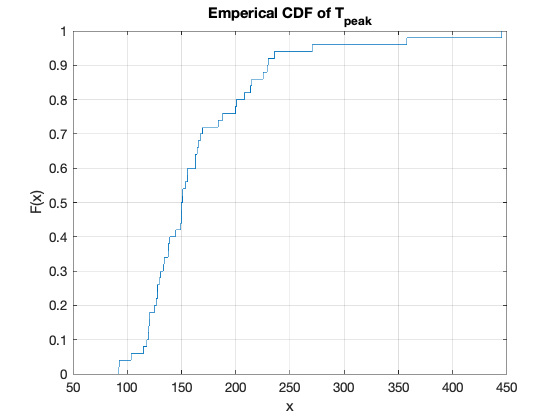

In [321]:
[h,stats] = cdfplot(features(:,7));
title("Emperical CDF of T_{peak}")
stats

stats = 
  struct with fields:

       min: 0.1475
       max: 1.0031
      mean: 0.8988
    median: 0.9392
       std: 0.1413



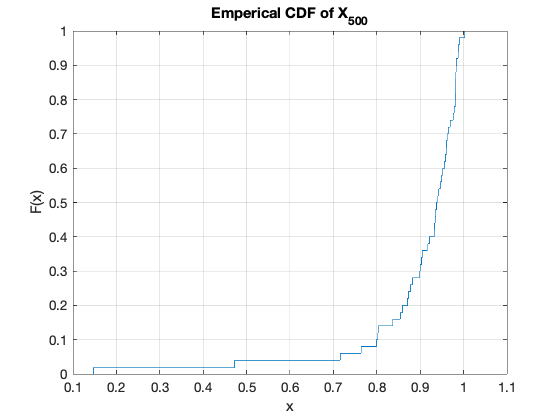

In [322]:
[h,stats] = cdfplot(features(:,8));
title("Emperical CDF of X_{500}")
stats

Recall, the sample `mean` value is an approximation of the expected value, or **expectation** of the random variable. The sample **variance** is the square of the sample standard deviation `std`.    

Check the correlation between the features.

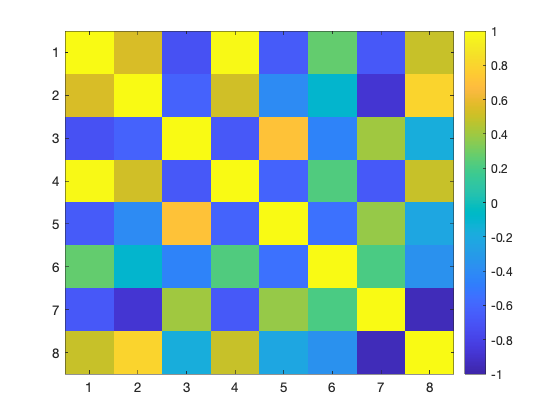

In [323]:
rho = corrcoef(features);
imagesc(rho, [-1 1]);
colorbar;

Recall, the (sample) correlation of two (samples of) random variables $X$ and $Y$ their (sample) **covariance** normalized (divided) by the product of their (sample) standard deviation.

*Discuss your findings. Your answer goes here.*

## Try to fit parametric probability distributions

We go through a set of common probability distributions and try to fit any of them  to the data. We use the Chi-square and the Kolmogorov-Smirnov tests to check the goodness of fit. 

*Note that fitting and testing using the same data is actually not quite correct. We should use cross-validation.*

In [324]:
%%file distribution_fitting.m
function pd = distribution_fitting(feature)
    distnames =["Poisson", "Exponential", "Gamma", "ExtremeValue", "Kernel"];
    values_must_be_positive =["Poisson", "Exponential", "Gamma"];
    x=feature.';
    x_values = linspace(min(x),max(x));
    for dn=distnames
        if min(x)<0 & ~isempty(find(strcmp(dn, values_must_be_positive)))
          continue;
        end
        distname = char(dn);
        pd = fitdist(x.',distname);
        res1=kstest(x, 'CDF', pd); 
        res2=chi2gof(x, 'CDF', pd);
        if (~res1 && ~res2)
            fprintf('%s with 5%% significance level\r',distname);
            cdfplot(x)
            hold on
            plot(x_values,cdf(pd,x_values),'r-')
            plot(x_values,pdf(pd,x_values),'g-')
            legend('Empirical CDF',[distname ' CDF'],[distname ' PDF'],'Location','best');
            %title(['Empirical CDF and ', [distname ' CDF/PDF']);
            hold off 
            return;
        else 
            fprintf('Not %s with 5%% significance level\n',distname);
        end
    end
end

Created file '/Users/wlomsi/Documents/ProjekteUni/Vorlesungen/ML 4DV660+4DV652/Notebooks/distribution_fitting.m'.


Not Poisson with 5% significance level
Not Exponential with 5% significance level
ans = 
  GammaDistribution

  Gamma distribution
    a = 3.37105   [2.31869, 4.90103]
    b = 1.63474   [1.09195, 2.44736]




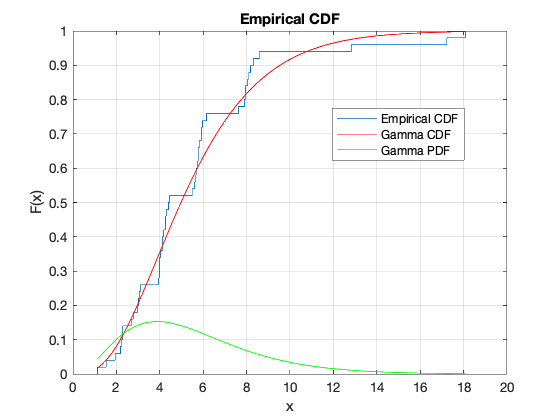

In [325]:
distribution_fitting(features(:,1))

Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
ans = 
  ExtremeValueDistribution

  Extreme Value distribution
       mu = 30.1544   [28.3336, 31.9751]
    sigma = 6.28696   [4.9552, 7.97664]




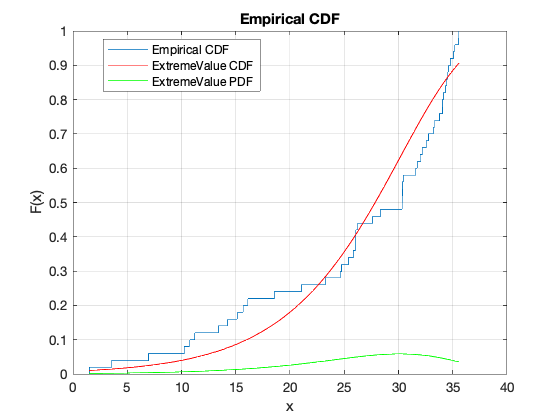

In [326]:
distribution_fitting(features(:,2))

Not Poisson with 5% significance level
Not Exponential with 5% significance level
ans = 
  GammaDistribution

  Gamma distribution
    a = 4.59304   [3.14535, 6.70704]
    b = 1.77341   [1.18864, 2.64587]




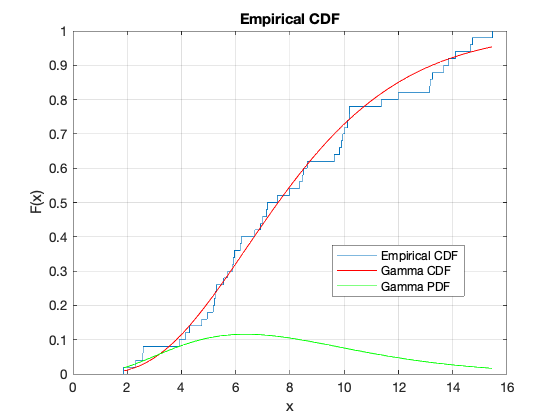

In [327]:
distribution_fitting(features(:,3))

Not Poisson with 5% significance level
Not Exponential with 5% significance level
ans = 
  GammaDistribution

  Gamma distribution
    a =  2.10901   [1.46371, 3.0388]
    b = 0.520437   [0.344661, 0.785857]




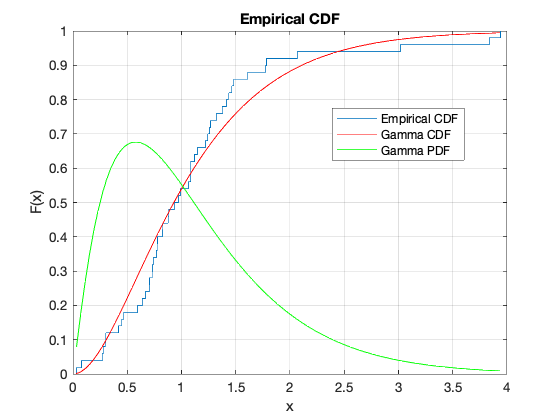

In [328]:
distribution_fitting(features(:,4))

ans = 
  ExtremeValueDistribution

  Extreme Value distribution
       mu = 1.49958   [1.01953, 1.97964]
    sigma = 1.64835   [1.31672, 2.06349]




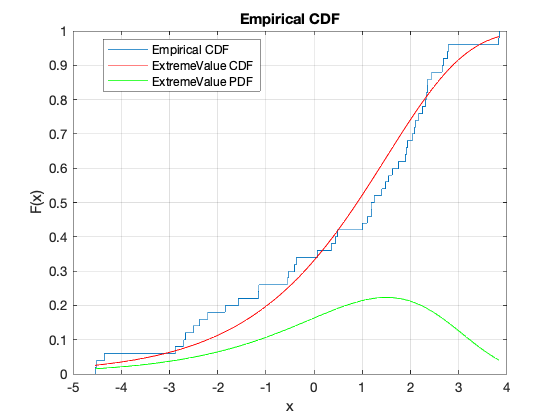

In [329]:
distribution_fitting(features(:,5))

ans = 
  ExtremeValueDistribution

  Extreme Value distribution
       mu = -0.978194   [-1.13856, -0.817826]
    sigma =   0.54497   [0.44751, 0.663654]




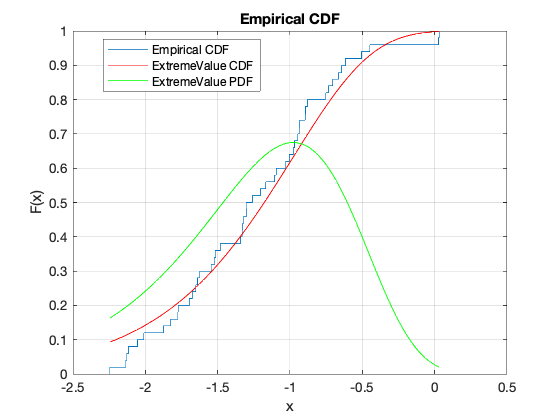

In [330]:
distribution_fitting(features(:,6))

Not Poisson with 5% significance level
Not Exponential with 5% significance level
ans = 
  GammaDistribution

  Gamma distribution
    a = 9.73574   [6.62162, 14.3144]
    b = 17.1703   [11.5607, 25.5018]




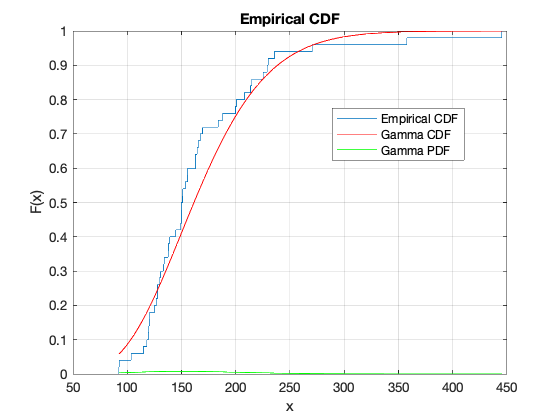

In [331]:
distribution_fitting(features(:,7))

Not Poisson with 5% significance level
Not Exponential with 5% significance level
Not Gamma with 5% significance level
ans = 
  ExtremeValueDistribution

  Extreme Value distribution
       mu = 0.943569   [0.925829, 0.961309]
    sigma = 0.062171   [0.0487856, 0.0792289]




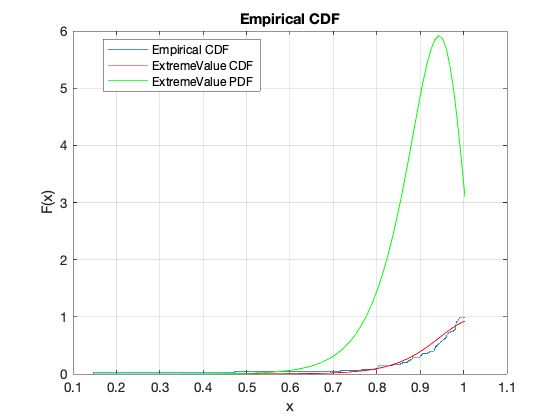

In [332]:
distribution_fitting(features(:,8))

*Describe the fitted distributions. Your answer goes here.*

## Joint  and conditional probabilities, chain rule and Bayes' Theorem

Lets calculate the probability of having a mild start and a disastrous end of the epidemia. We translate that to the **joint probability** that no more $4\%$ are infected after $50$ days, i.e., $N_{50}\leq 4\%$ and more than $0.95\%$ die in the end, i.e., $X_{500}>0.95\%$.

In [354]:
n_50 = features(:,1);
x_500 = features(:,8);
positive_cases = length(intersect(find(n_50<=4),find(x_500>0.95)))
all_cases = length(features);
P = positive_cases/all_cases

positive_cases =
     1
P =
    0.0200



So $P(N_{50}\leq 4\%, X_{500}>0.95\%) \approx 0.02$.

We check the product of the two probabilities $P(N_{50}\leq 4\%)P(X_{500}>0.95\%)$:

In [353]:
P2 = length(find(n_50<=4))/all_cases * length(find(x_500>0.95))/all_cases

P2 =
    0.1428



We are not surprised that the result is different from the joint probability as the random variables $N_{50}$ and $X_{500}$ not independent (double-check the results from the correlation analysis).  

What is the **conditional probability** of more than $0.95\%$ die in the end given that we know that no more $4\%$ are infected after $50$ days.

In [345]:
mild_start_cases = length(find(n_50<=4));
P_AB = positive_cases/mild_start_cases

P_AB =
    0.0588



So $P(X_{500}>0.95\%|N_{50}\leq 4\%) \approx 0.0588$.

The product or **chain rule** of probability states that

\begin{align}
P(A,B) &= P(A|B)P(B)\\
P(X_{500}>0.95\%,N_{50}\leq 4\%) &= P(X_{500}>0.95\%|N_{50}\leq 4\%)P(N_{50}\leq 4\%)
\end{align}

And we don't get disappointed:

In [357]:
P_B = mild_start_cases/all_cases;
P = P_AB*P_B

P =
    0.0200



Let us numerically confirm **Bayes' Theorem** for this case. We'd expect that  

\begin{align}
P(A|B) &= \frac{P(B|A)P(A)}{P(B)}\\
P(X_{500}>0.95\%|N_{50}\leq 4\%) &= \frac{P(N_{50}\leq 4\%|X_{500}>0.95\%)P(X_{500}>0.95\%)}{P(N_{50}\leq 4\%)}
\end{align}

And we don't get disappointed:

In [351]:
disaster_cases = length(find(x_500>0.95));
P_A = disaster_cases/all_cases;
P_BA = positive_cases/disaster_cases;
P_AB = P_BA*P_A/P_B

P_AB =
    0.0588



So far, we have looced at the joint (sample) probability of $P(N_{50}\leq n, X_{500}>x)$ for *concrete* bounds $n=4$ and $x=0.95$. Let us now understand the joint (sample) probability of $F(n,x)=P(N_{50}\leq n, X_{500}>x)$ as a *function* of these bounds $n$ and $x$. Since, $0\leq X_{500}\leq 100$ this function is equal to joint (sample) cumulative distribution function: 

\begin{align}
F(n,x) &=\mathit{CDF}_{N_{50},100-X_{500}}(n,100-x)\\
\mathit{CDF}_{N_{50},100-X_{500}}(n,y)&=P(N_{50}\leq n, 100-X_{500}\leq y)
\end{align}

In `Matlab`, we can numerically approximate such a joint $\mathit{CDF}_{X,Y}(x,y)$:

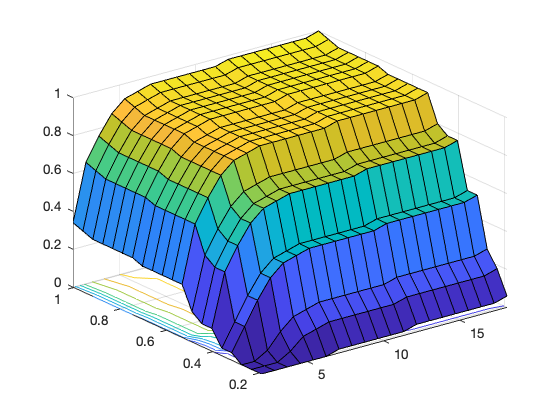

In [373]:
addpath('/Users/wlomsi/Documents/MATLAB/ecdfbiv');
joint_CDF=ecdfbiv([n_50, 100-x_500],20,20);
surfc(x_c,y_c,joint_CDF);

*Interprete this CDF. Your answer goes here.*

## References

1. Amira Rachah and Delfim F. M. Torres: Mathematical Modelling, Simulation, and Optimal Control of the 2014 Ebola Outbreak in West Africa. Discrete Dynamics in Nature and Society, Volume 2015, Article ID 842792, https://www.hindawi.com/journals/ddns/2015/842792/.